## Importing Pandas and Reading the Dataset

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv(r"titanic/train.csv")

In [4]:
df.head(), df.isna().sum()

(   PassengerId  Survived  Pclass  \
 0            1         0       3   
 1            2         1       1   
 2            3         1       3   
 3            4         1       1   
 4            5         0       3   
 
                                                 Name     Sex   Age  SibSp  \
 0                            Braund, Mr. Owen Harris    male  22.0      1   
 1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
 2                             Heikkinen, Miss. Laina  female  26.0      0   
 3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
 4                           Allen, Mr. William Henry    male  35.0      0   
 
    Parch            Ticket     Fare Cabin Embarked  
 0      0         A/5 21171   7.2500   NaN        S  
 1      0          PC 17599  71.2833   C85        C  
 2      0  STON/O2. 3101282   7.9250   NaN        S  
 3      0            113803  53.1000  C123        S  
 4      0            373450   8.0500

## Building a Preprocessing Pipeline

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [6]:
# Defining the target and features 
target = "Survived"
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

In [7]:
X = df[features].copy()
y = df[target].copy()

In [8]:
# Grouping the columns into Numerical and Categorical
num_cols = ["Age", "SibSp", "Parch", "Fare"]
cat_cols = ["Sex", "Embarked", "Pclass"]

In [9]:
# Numerical Columns Transfomer

num_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

In [10]:
# Categorical Columns Transformer

cat_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [11]:
# 

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols),
    ],
    remainder="drop"
)

In [15]:
# Decision Tree Pipeline

pipe_dt = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(random_state=42))
])

In [16]:
# Defining the parameter grid

param_grid = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_depth": [3, 4, 5, 6, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 5]
}

In [17]:
# Defining the Grid Search CV

grid_dt = GridSearchCV(
    estimator=pipe_dt,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

In [18]:
grid_dt.fit(X, y)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__criterion': ['gini', 'entropy', ...], 'clf__max_depth': [3, 4, ...], 'clf__min_samples_leaf': [1, 2, ...], 'clf__min_samples_split': [2, 5, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [20]:
# Taking the best estimator from the grid search

best_dt = grid_dt.best_estimator_
best_dt.get_params()

{'memory': None,
 'steps': [('prep', ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median'))]),
                                    ['Age', 'SibSp', 'Parch', 'Fare']),
                                   ('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ohe',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    ['Sex', 'Embarked', 'Pclass'])])),
  ('clf',
   DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=2,
                          min_samples_split=10, random_state=42))],
 'transform_input': No

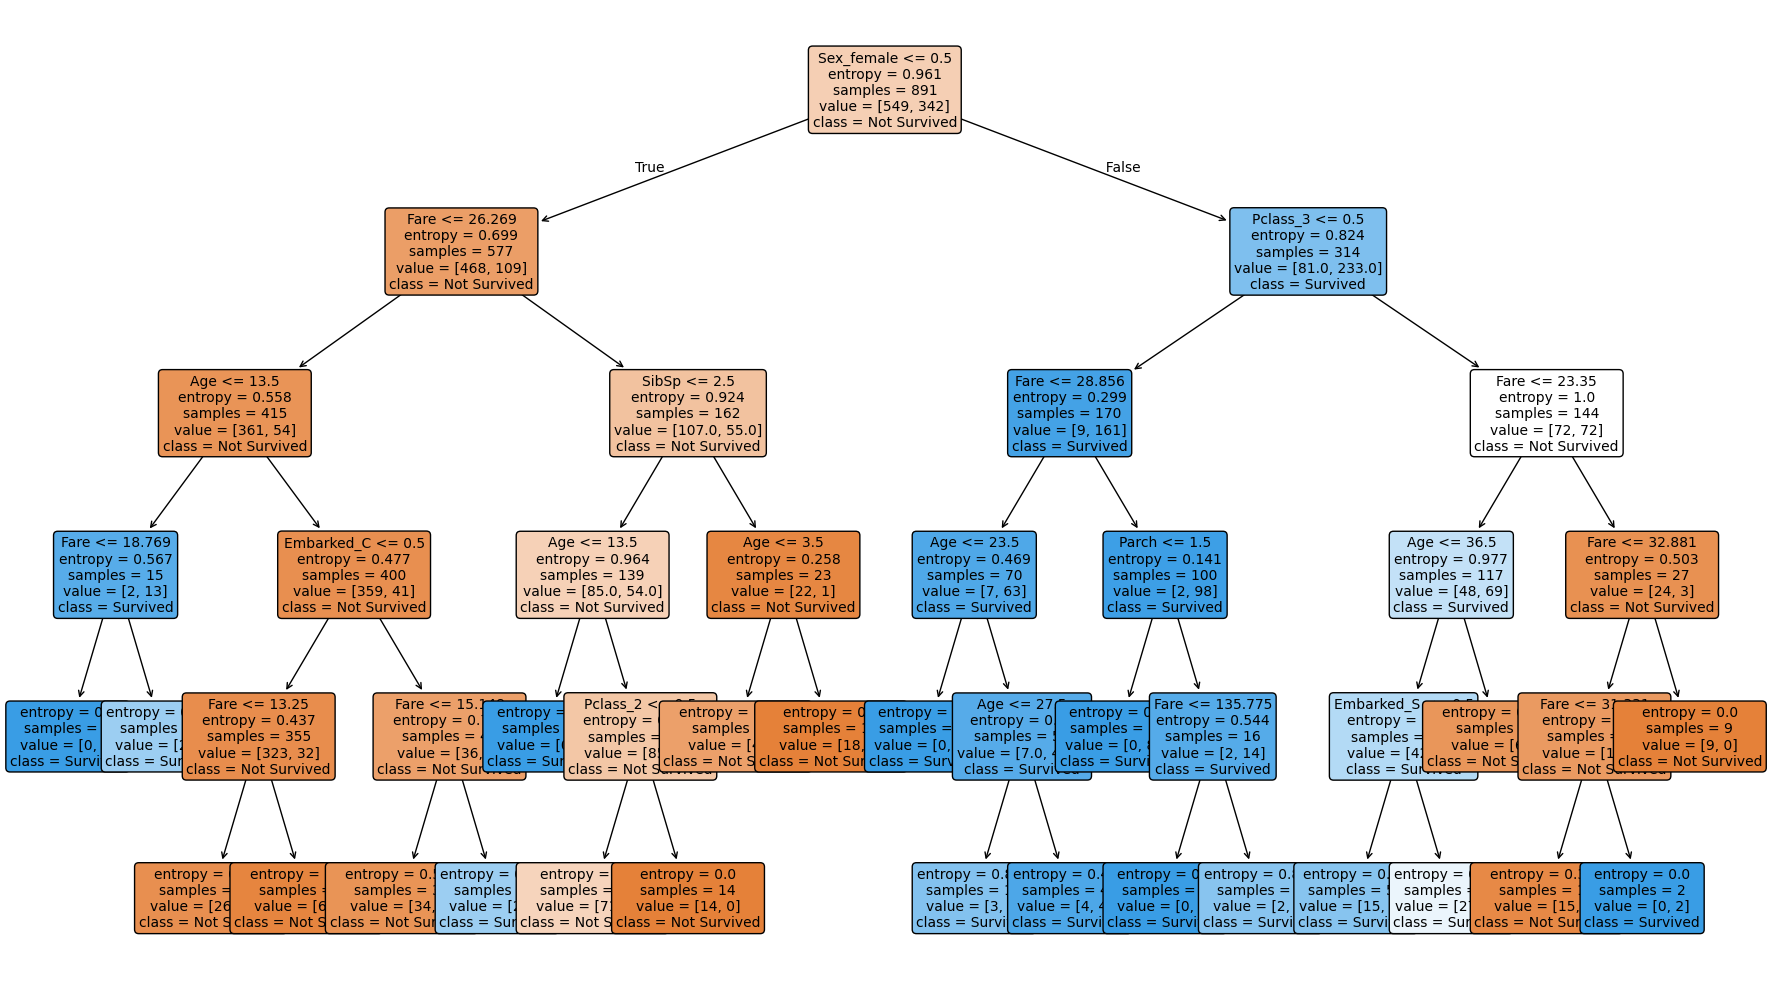

In [21]:
# Extract feature names after preprocessing (for readable plot)
ohe = best_dt.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out(cat_cols)
feature_names = list(num_cols) + list(cat_names)

dt_model = best_dt.named_steps["clf"]

plt.figure(figsize=(18, 10))
plot_tree(
    dt_model,
    filled=True,
    feature_names=feature_names,
    class_names=["Not Survived","Survived"],
    rounded=True,
    fontsize=10
)
plt.tight_layout()
plt.show()

In [22]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [23]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    estimator=best_dt,
    X=X, y=y,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

In [24]:
print("Fold accuracies:", [round(s, 4) for s in scores])
print(f"Average accuracy: {scores.mean():.4f}")
print(f"Std dev: {scores.std():.4f}")

Fold accuracies: [np.float64(0.838), np.float64(0.8258), np.float64(0.7978), np.float64(0.8202), np.float64(0.8371)]
Average accuracy: 0.8238
Std dev: 0.0146


In [25]:
from sklearn.ensemble import RandomForestClassifier